## Interpolation of the S&P 500 option price surface using Gaussian Process Regression with exponential kernel

Disclaimer: 
<br> This solution is showcased to share my understanding of the problem and my own approach to it.
<br> This solution is not intended for any general application.

#### For questions, suggestions and further details, please feel free to contact me at juan-carlos.ramirez@warwick.ac.uk

---------

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import datetime as dt
import sklearn.gaussian_process as GP
from sklearn.metrics import r2_score as R2 
from sklearn.model_selection import train_test_split
# Random State used accross the notebook
rnd_state = 12345
# Plots Style
sns.set_theme()
sns.set_palette(palette="winter")
plt.rcParams['figure.figsize'] = [12, 6]
# DataFrame printing style
pd.set_option('display.float_format', lambda x: '%.2f' % x)

----------
## Data sources (Steps 1 to 3)
We use data from the Wharton Research Data Service of the University of Pennsilvania. Details can be found in [6]

In [2]:
# SPX Option price data
# Features we will use in the model
Wanted = ['optionid','date','exdate','strike_price',
          'volume','best_bid','best_offer']
# Exctract data and format it
Data = pd.read_csv('5.1 GP Option price interpolation data.csv').loc[:,Wanted]
Data = Data.set_index('optionid',drop=True)
Data.columns = ['Date','Maturity','Strike','Volume','Bid','Ask']
# Change scale of Strike feature (as explained in the WRDS documentation).
Data.Strike /= 1000
# Visualize the first 5 examples
Data.head(5)

,Date,Maturity,Strike,Volume,Bid,Ask
optionid,,,,,,
127164667,02/01/2020,17/01/2020,1000.00,900,2251.60,2258.70
124311326,02/01/2020,17/01/2020,1100.00,0,2151.70,2158.80
127126696,02/01/2020,17/01/2020,1150.00,0,2101.70,2108.80
124227746,02/01/2020,17/01/2020,1200.00,0,2051.80,2058.90
127262304,02/01/2020,17/01/2020,1225.00,0,2026.80,2033.90


Variables description:
- OptionID: Unique ID of the Option
- Date: Date of the quote
- Maturity: Exercise date of the option
- Strike: Strike price of the option
- Volume: Closing Volume for the option
- Bid: Highest Closing Bid Across All Exchanges
- Ask: Lowest Closing Ask Across All Exchanges

More information about S&P 500 CBOE Standard Options in [7]

-------------
## Data transformation

We transform our data with the objective of creating the features we want to use in our modelling, in this case, just feature DtM, which represent the number of days an option needs to expire.

In [3]:
# Create DtM 'Days to Maturity' variable
Data.Date = Data.Date.apply(lambda x: dt.strptime(x,'%d/%m/%Y'))
Data.Maturity = Data.Maturity.apply(lambda x: dt.strptime(x,'%d/%m/%Y'))
Data['DtM'] = (Data.Maturity - Data.Date).apply(lambda x: x.days)

-------------
## Motivation (Step 4)

#### **What do you want to predict?**
Our final task is to be able to hedge an investment portfolio that is highly correlated with the S&P 500 index, for this purpose, we turn our attention to CBOE's S&P 500 European Call Options, which are instruments mainly designed to help investors manage risk in their portfolios.

Since our objective is to hedge our portfolio, and we realized that options can help us with this, we now want to be able to know the price at which this instruments can be immediately bought in the market (we focus on immediate buying since delaying our hedging can incur in additional risk), so we will focus in modelling the **Lowest selling price among all exchanges (Ask price)** of the options.

Furthermore, since our objective is to predict **Ask prices** for future transactions, or for non-traded options (i.e. options with no volume nor open interest), we consider options with **Ask-Bid** information relevant, even when they have no trading volume (i.e. there was negotiation for the instrument, but no actual closure, hence no trade).

#### **Which variables are possible predictors?**
For the purpose of our wanted prediction, we will make use of the Wharton Research Data Services (WRDS) Option Metrics data base, which contains several features, among we chose the following (and give a brief justification for doing so):
- **Days to Maturity (DtM)**, since maturity is one of the main parameters of any derivative, hence a price driver.
- **Strike price (Strike)**, since the strike price is one of the main parameters of any option, hence a price driver.
- **Volume (Volume)**, since it can tell us how representative the prices are, high volume in a certain contract tell us that the price is highly representative of the market consensus.

------------
## Data Exploration (Step 4 details)

In this section, our aim is to visualize our data and try to understand what kind of behaviour it has, since options are dependent on many variables, we create 2 different plots to visualized the behaviour through **Time-Volume pairs** and **Price Surface**. Please take into consideration that this plots only represent a sample from our data and not the complete picture.

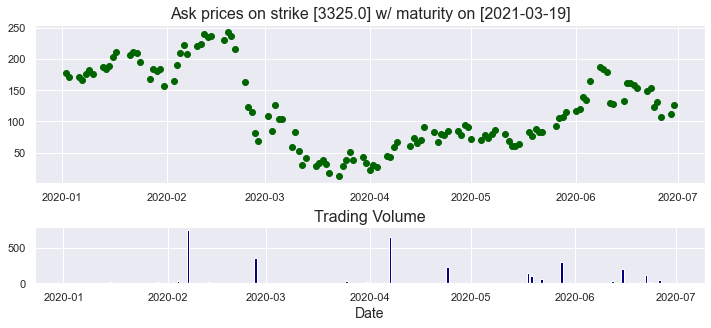

In [4]:
# Price Movement on time
temp = Data.loc[131682855]
Strike = temp.Strike.values[0]
Maturity = temp.Maturity.value_counts().idxmax()
top_plt = plt.subplot2grid((6,4), (0, 0), rowspan=3, colspan=4)
top_plt.scatter(temp.Date,temp['Ask'],color='darkgreen')
plt.title('Ask prices on strike ['+str(Strike)+\
          '] w/ maturity on ['+ str(Maturity.date()) +']',fontsize=16)
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(temp.Date, temp['Volume'], color='navy')
bottom_plt.set_xlabel('Date',fontsize=14)
plt.title('Trading Volume',fontsize=16)
plt.show()

From the previous figure, we obtain two important insights: 
- There are significant time differences between trades (observed in the "Trading Volume" plot), which is bad news for our intentions since no hedging strategy is useful in an illiquid market.
- The price of the option does have change points from time to time, as observed between 2020-02 and 2020-03.

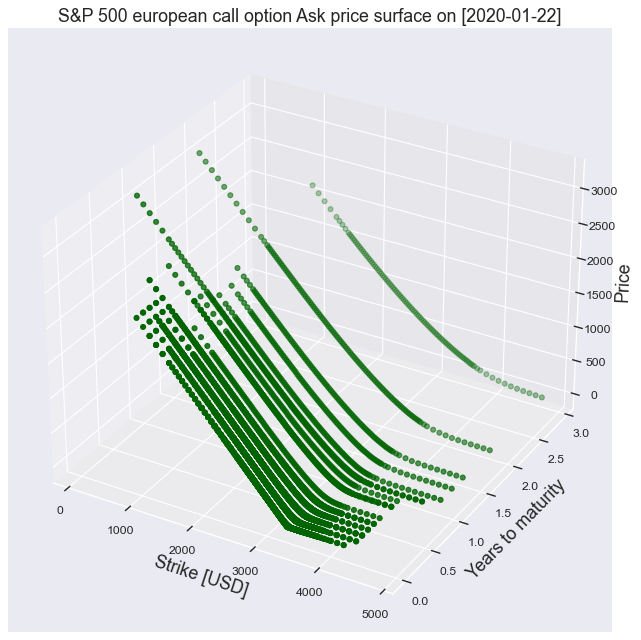

In [5]:
Date = pd.Timestamp('2020-01-22')
temp = Data.loc[Data.Date == Date]
X = temp.Strike
Y = (temp.DtM/365).apply(lambda x: round(x,1))
Z = temp.Ask

fig = plt.figure(figsize=(10, 10),dpi=80)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, color='darkgreen', marker='o')

plt.title('S&P 500 european call option Ask price surface on ['+\
          str(Date.date())+']',fontsize=16)
ax.set_xlabel('Strike [USD]',fontsize=16)
ax.set_ylabel('Years to maturity',fontsize=16)
ax.set_zlabel('Price',fontsize=16)
plt.show()

In this plot, which we will call the Ask price surface (drawing inspiration for the known object "Volatility Surface"), we can observe two important insights: 
- The surface is not completely explored by the market, i.e., some pairs Strike-Maturity are not priced by the market. For hedging purposes, a smooth surface is ideal, hence we get the task of completing our observed surface using Gaussian Processes.
- There is more data density around 3300, which was approximately the price of the S&P 500 index on our sample date.

-----------
## Data modelling
In this section, we get into the task of modelling the **Ask prices** of our options, with the motivation explained before.

### Step 5: Kernel selection

First, we must choose a Kernel to describe the covariance structure of our Gaussian process. Based on the exploration in the previous section, we decide to use the **Squared exponential (SE) kernel**, also known as the **Radial basis function kernel** or **Gaussian Kernel**, multiplied by a **Constant Kernel**, with the intention of capturing the fitted **Gaussian process** variance. 

This **Kernel** is selected since, as mentioned before, a smooth price surface is ideal for hedging and risk management in general, the SE Kernel fulfils this property by having an infinite number of derivatives. Moreover, this matches the behaviour of options prices under the **Black - Scholes & Merton** model, which also is infinitely differentiable (many of them known as "Greeks").

Furthermore, we make use of a constant value to scale our **SE** component of the kernel, but let it to be 1, the reason is that we are going to normalize our target **Ask** prices when passing them to the **Gaussian Process**, so we expect them to have **mean 0** and **variance 1**

In [6]:
# Variance of the Gaussian process captured by the constant Kernel
# Guide on [4]
Var = GP.kernels.ConstantKernel(constant_value=1.0,
                                constant_value_bounds='fixed')
# Squared Exponential Kernel for a smooth process
# Guide on [5]
SE = GP.kernels.RBF(length_scale=1.0,
                    length_scale_bounds=(1e-7, 1e7))
# Final Kernel
Kernel = Var * SE

### Step 6: Data selection

Next, we sample 2000 entries of our data to create our Target and Design Matrices, since using the entirety of the data is not feasible, due to the Gaussian process computational expense increasing in cubic order with relation to the sample size, and chose a test size of 20% those 2000 entries.

In [7]:
# Drop non-modelling features
ModData = Data.drop(['Date','Maturity','Bid'],axis=1)
ModData = ModData.applymap(float)
# Split sample of data set
Sample = ModData.sample(n=2000, random_state=rnd_state)
Target = Sample[['Ask']].reset_index(drop=True)
DesingMatrix = Sample.drop(['Ask'],axis=1).reset_index(drop=True)
x_tr, x_te, y_tr, y_te = train_test_split(DesingMatrix, Target,
                                          test_size=0.20, random_state=rnd_state)

Finally, we fit the **Gaussian process** with our selected kernel, with the following considerations:
- We must add something to the covariance matrix during fitting to avoid numerical issues, that value is represented by **alpha** in the next function.
- We expect the price of the options to be "centred" around 0, since that is the price of an **At the money** option, which we saw in Step 4 is the most traded interval, hence, we want to incorporate this to our prior, so it has mean 0 and unit variance. This is reflected with **normalize_y=True**.

In [8]:
# Guide on [3]
Model = GP.GaussianProcessRegressor(kernel=Kernel, n_restarts_optimizer=10,
                                    alpha=1e-1, normalize_y=True, random_state=rnd_state)
# Fit the modeel (by default uses Maximum Likelihood Estimation)
FittedModel = Model.fit(x_tr, y_tr)

------
## Goodness of Fit (Step 7)

In this section, we will explore our fitted **Gaussian process** performance in a visual way.

First, we start by using our test data to evaluate our **Gaussian process** posterior.

In [9]:
# Predict using the fitted model
y_pr, std = Model.predict(x_te, return_std=True)
# Since negative prices do not make sense in the case of Long Call options
y_pr = np.maximum(y_pr,0) # this case represents around 3% of our predictions
Rsqr = R2(y_te,y_pr)
# Results Data Frame
Prediction = pd.concat([pd.Series(y_pr[:,0],index=x_te.index,name='Pred_Ask'),x_te],axis=1)

And now, we start presenting some plots to visualize the goodness of fit.

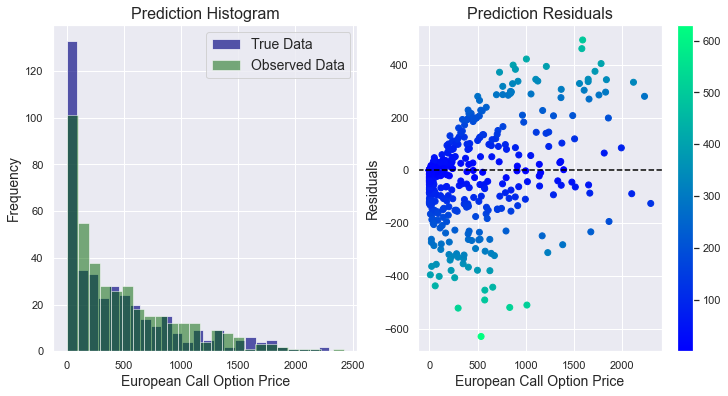

In [10]:
# Illustrative Plots
plt.subplot(121)
plt.hist(y_te, alpha=0.65, bins=25, label='True Data', color='navy')
plt.hist(y_pr, alpha=0.50, bins=25, label='Observed Data', color='darkgreen')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('European Call Option Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Prediction Histogram',fontsize=16)

plt.subplot(122)
sc = plt.scatter(y_te, y_te-y_pr, c=(y_te-y_pr).Ask.abs())
plt.colorbar(sc)
plt.axhline(0.0, linestyle='--',color='black')
plt.xlabel('European Call Option Price', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Prediction Residuals',fontsize=16)
plt.winter()

plt.show()

The previous two plots tell us more about the details of the performance of the **Gaussian process**:
- In the left hand, we see a histogram comparing the true observed prices of our test set with the predicted values acquired evaluating the **Gaussian posterior** in our test design matrix.
- In the right hand, we have a residual plot explained by the option price, we can observe consistent residuals, and they mostly concentrate around our ideal value (zero), with some few outliers, like some errors of around -600 and 1500.

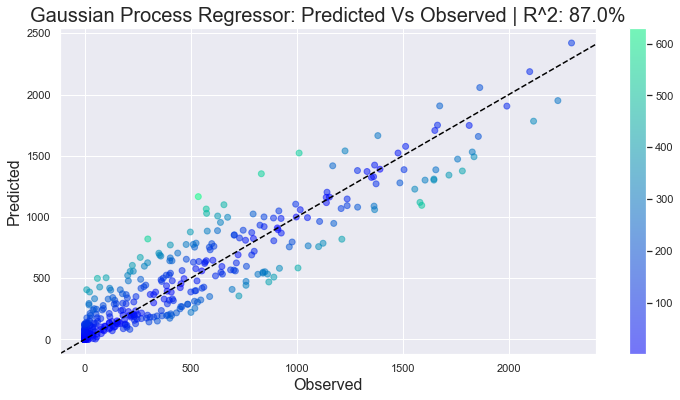

In [11]:
# Quick function that adds the identity line to the plot.
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

# Scatter of residuals
f, ax = plt.subplots()
plt.title('Gaussian Process Regressor: Predicted Vs Observed | R^2: '+\
          str(round(Rsqr*100,0))+'%', fontsize=20)
sc = ax.scatter(y_te, y_pr, alpha = .5, c=(y_te-y_pr).Ask.abs())
plt.colorbar(sc)
add_identity(ax, color='black', ls='--')
plt.xlabel('Observed', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.winter()
plt.show()

Here we see that the **Gaussian process** is doing an excellent job fitting to the observed option prices, a bit too good (please note that the R^2 in the tittle is 87.0%), further investigation and testing is advised to rule out overfitting.

-------------
## References
Not directly used, but reviewd

[1] Roberts S., Osborne M., Ebden M., Reece S., Gibson N. and Aigrain S. 2013, Gaussian processes for time-series modelling, Phil. Trans. R. Soc. A.371: 20110550. 20110550. https://doi.org/10.1098/rsta.2011.0550

[2] Tegnér M., Stephen R., [Work in Progress], A Bayesian take on option pricing with Gaussian processes, University of Oxford, Department of Engineering & Oxford-Man Institute. https://www.robots.ox.ac.uk/~mt/pdfFiles/GPLV.pdf

[3]: Scikit-Learn, Gaussian Process Regression, https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html, (accesed: 12/19/2021)

[4]: Scikit-Learn, Constant Kernel, https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html, (accesed: 12/19/2021)

[5]: Scikit-Learn, RBF Kernel, https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html, (accesed: 12/19/2021)

[6] Wharton Research Data Service, OptionMetrics, https://wrds-www.wharton.upenn.edu/login/?next=/pages/support/manuals-and-overviews/optionmetrics/wrds-overview-optionmetrics/ (accesed: 12/19/2021)

[7] Chicago Board Options Exchange, S&P 500 Option Product Specification, https://www.cboe.com/tradable_products/sp_500/spx_options/specifications/ (accesed: 12/19/2021)